In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from collections import namedtuple
from scipy.optimize import curve_fit

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 2.5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#aaaaaa"
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

Values = namedtuple('Values', 'label values')

def plot(data: dict, x_name: str, y_name: str, fmt='.', x_min=None, x_max=None, y_min=None, y_max=None, approx_range=None, approx_order=1):
    fig = plt.figure()
    ax = plt.axes()
    for name, data in data.items():
        x_data = data[x_name].values
        y_data = data[y_name].values
        if len(x_data) != len(y_data):
            raise ValueError("x and y data must have the same length")
        
        idx = np.ones(len(x_data), dtype=bool)
        if x_min is not None:
            idx &= (x_data >= x_min)
        if x_max is not None:
            idx &= (x_data <= x_max)
        if y_min is not None:
            idx &= (y_data >= y_min)
        if y_max is not None:
            idx &= (y_data <= y_max)
        x_data = x_data[idx]
        y_data = y_data[idx]
            
        plot = ax.plot(x_data, y_data, fmt, label=name)
        color = plot[0].get_color()

        if approx_range is not None:
            approx_idx = (x_data >= approx_range[0]) & (x_data <= approx_range[1])
            x_data_approx = x_data[approx_idx]
            y_data_approx = y_data[approx_idx]
            z = np.polyfit(x_data_approx, y_data_approx, deg=approx_order)
            approx_x = np.linspace(min(x_data), max(x_data), 100)
            p = np.poly1d(z)
            print(z, p)
            p_str = ''.join([fr'{k:+.2e}{'}'}\cdot x^{len(z)-i-1}'.replace('e', r'\cdot 10^{') for i, k in enumerate(z)]).replace('x^1', 'x')[:-9]
            ax.plot(approx_x, p(approx_x), color=color, label=fr'{name}: ${p_str}$')

    ax.set_xlabel(data[x_name].label)
    ax.set_ylabel(data[y_name].label)
    # ax.set_title(f'{y_name} on {x_name}')
    plt.legend()
    fname = f'{y_name}_on_{x_name}'
    directory = 'out'
    if x_min is not None:
        fname += f'_xmin_{x_min}'
    if x_max is not None:
        fname += f'_xmax_{x_max}'
    if y_min is not None:
        fname += f'_ymin_{y_min}'
    if y_max is not None:
        fname += f'_ymax_{y_max}'

    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(f'{directory}/{fname}.png')

    plt.show()

In [17]:

# files = ['1_down.csv', '2_down.csv'] # , '3_down.csv'
files = ['1_down.csv']
L = {'1_down.csv': 31e-3, '2_down.csv': 27.6e-3}
R0_data = {'1_down.csv': 1.83e-1, '2_down.csv': 1.65e-1}
all_data = {}
for file in files:
    raw_data = np.genfromtxt(f'../../data/2025-02/{file}', delimiter='\t', names=True)[1:]

    I = raw_data['RIGOLcurrent']
    U = raw_data['KEYSIGHTvoltage']
    L0 = L[file]
    Unorm = U / L0
    
    R = U / I
    R0 = R0_data[file]
    print(f'R0 {file} {np.mean(R[-8:-2])}')
    R0 = np.mean(R[-8:-2])
    T0 = 293.15
    Tfunc = lambda RdivR0: T0 * RdivR0 ** (1/1.227)
    T = Tfunc(R/R0)

    sort_idx = np.argsort(I)
    I_sorted = I[sort_idx]
    T_sorted = T[sort_idx]
    T_spline = UnivariateSpline(I_sorted, T_sorted, s=3000)
    I_fine = np.linspace(I_sorted.min(), I_sorted.max(), 1000)
    dT_dI = T_spline.derivative()(I_fine)

    all_data[file] = {
        'rho': Values(label='Relative resistance', values=R/L0*(np.pi * (55e-6 ** 2))),
        'I': Values(label='Сила тока (A)', values=I),
        'U': Values(label='Voltage (V)', values=U),
        'U_norm': Values(label='Normalized voltage (V/m)', values=Unorm),
        'T': Values(label='Температура (K)', values=T),
        'dT_dI': Values(label='dT / dI', values=dT_dI),
        'I_fine': Values(label='Сила тока (A)', values=I_fine)
    }

R0 1_down.csv 0.18148851591943602


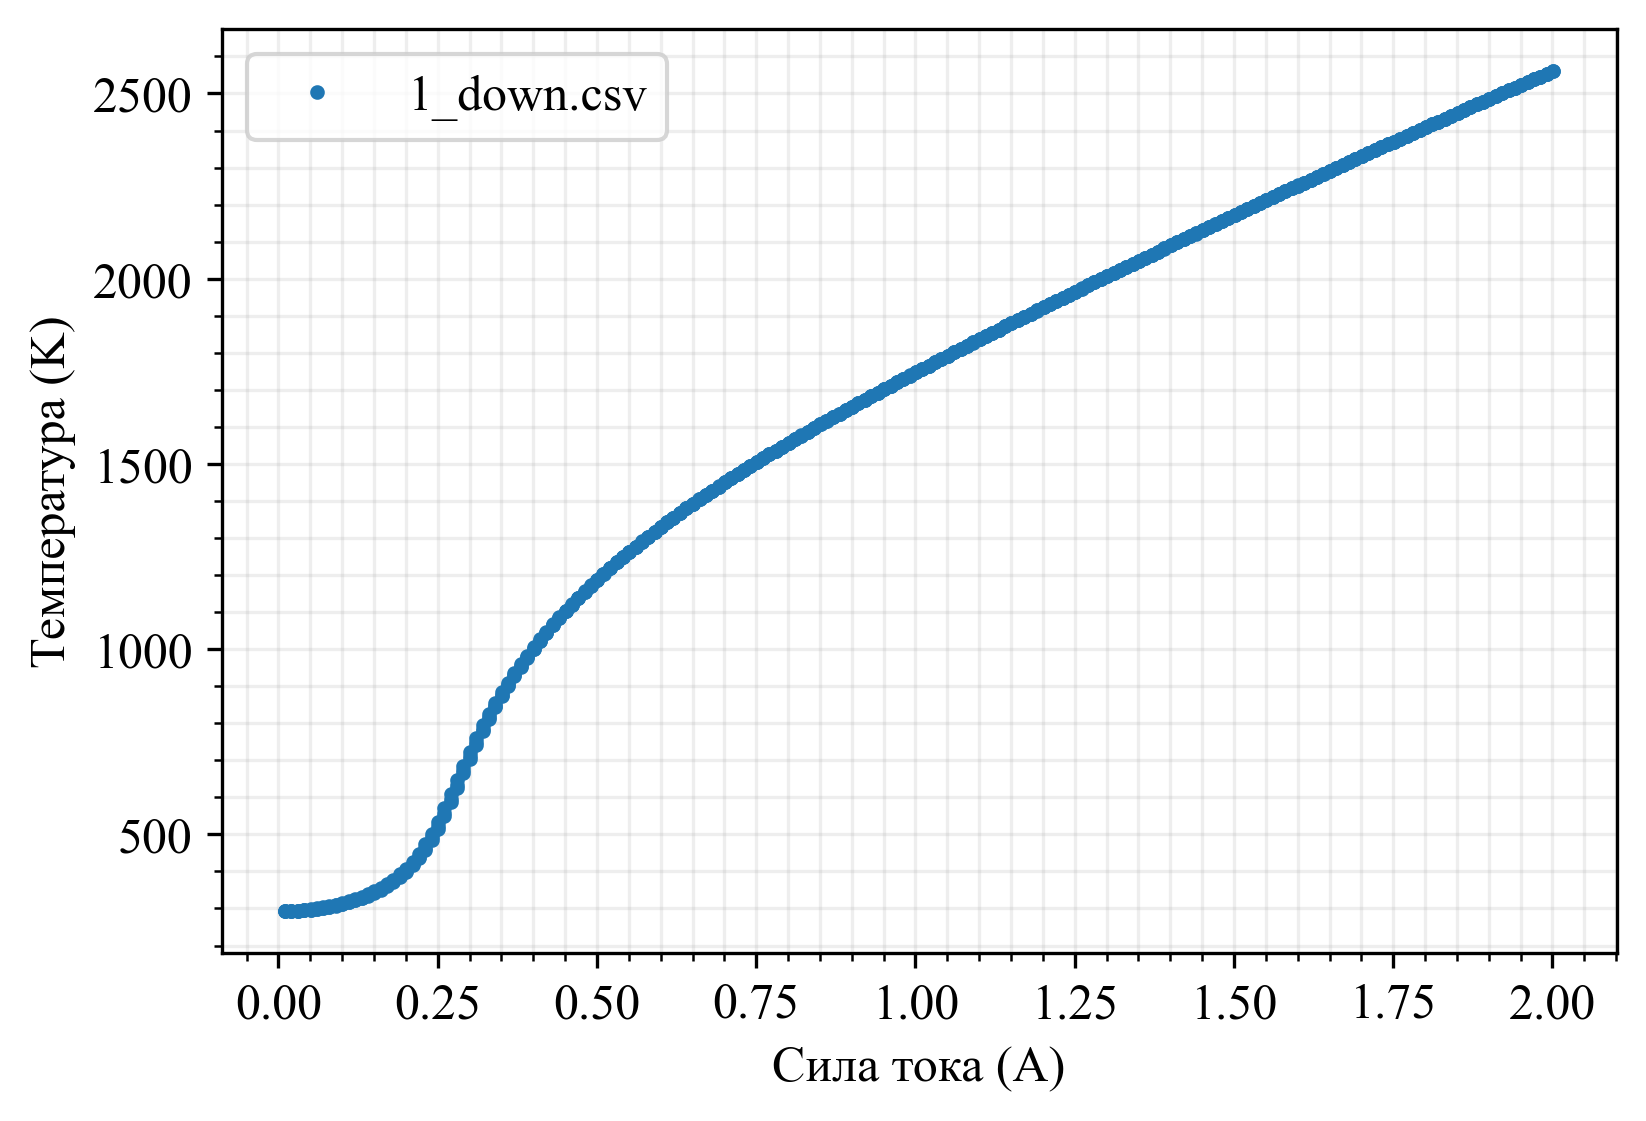

[ 2.57779047e-14  2.57358040e-10 -3.14622205e-08]            2
2.578e-14 x + 2.574e-10 x - 3.146e-08


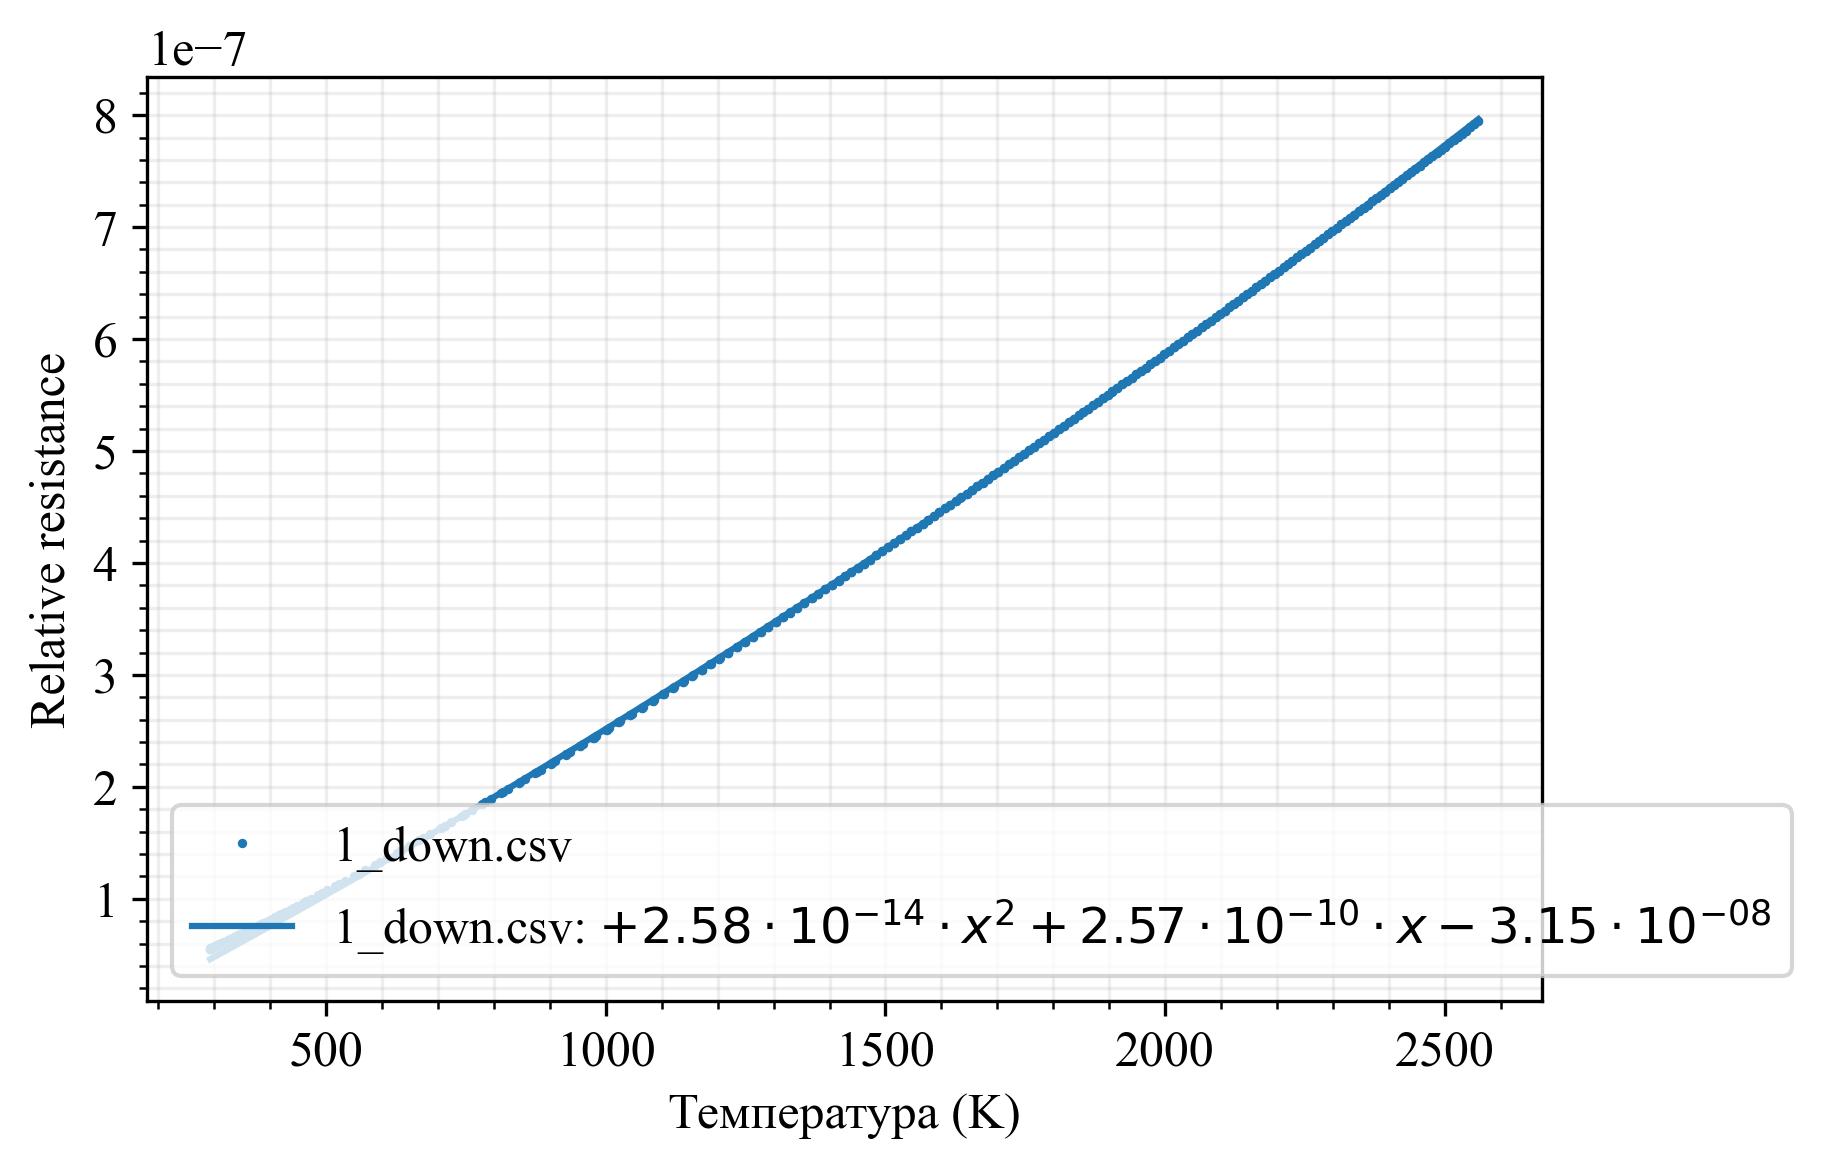

In [18]:
# plot(all_data, 'I', 'U_norm')
# plot(all_data, 'I', 'U_norm', fmt='.-', x_min=1.75)
# plot(all_data, 'I', 'U', fmt='o', x_max=0.25, approx_range=(0, 0.04))
# plot(all_data, 'I', 'U', fmt='o', x_max=0.25, approx_range=(0, 0.15), approx_order=2)
plot(all_data, 'I', 'T', fmt='o')
# plot(all_data, 'I', 'T', approx_range=(1.3,1.7), approx_order=1)
# plot(all_data, 'I', 'T', approx_range=(0.75,1.7), approx_order=3)
# plot(all_data, 'I_fine', 'dT_dI')
# plot(all_data, 'I_fine', 'dT_dI', x_min=1.25)
plot(all_data, 'T', 'rho', approx_range=(500, 2500), approx_order=2)

In [46]:
COOMSOL_data = np.loadtxt('COMSOL_60um_T_on_I.csv', delimiter=',', skiprows=5).T

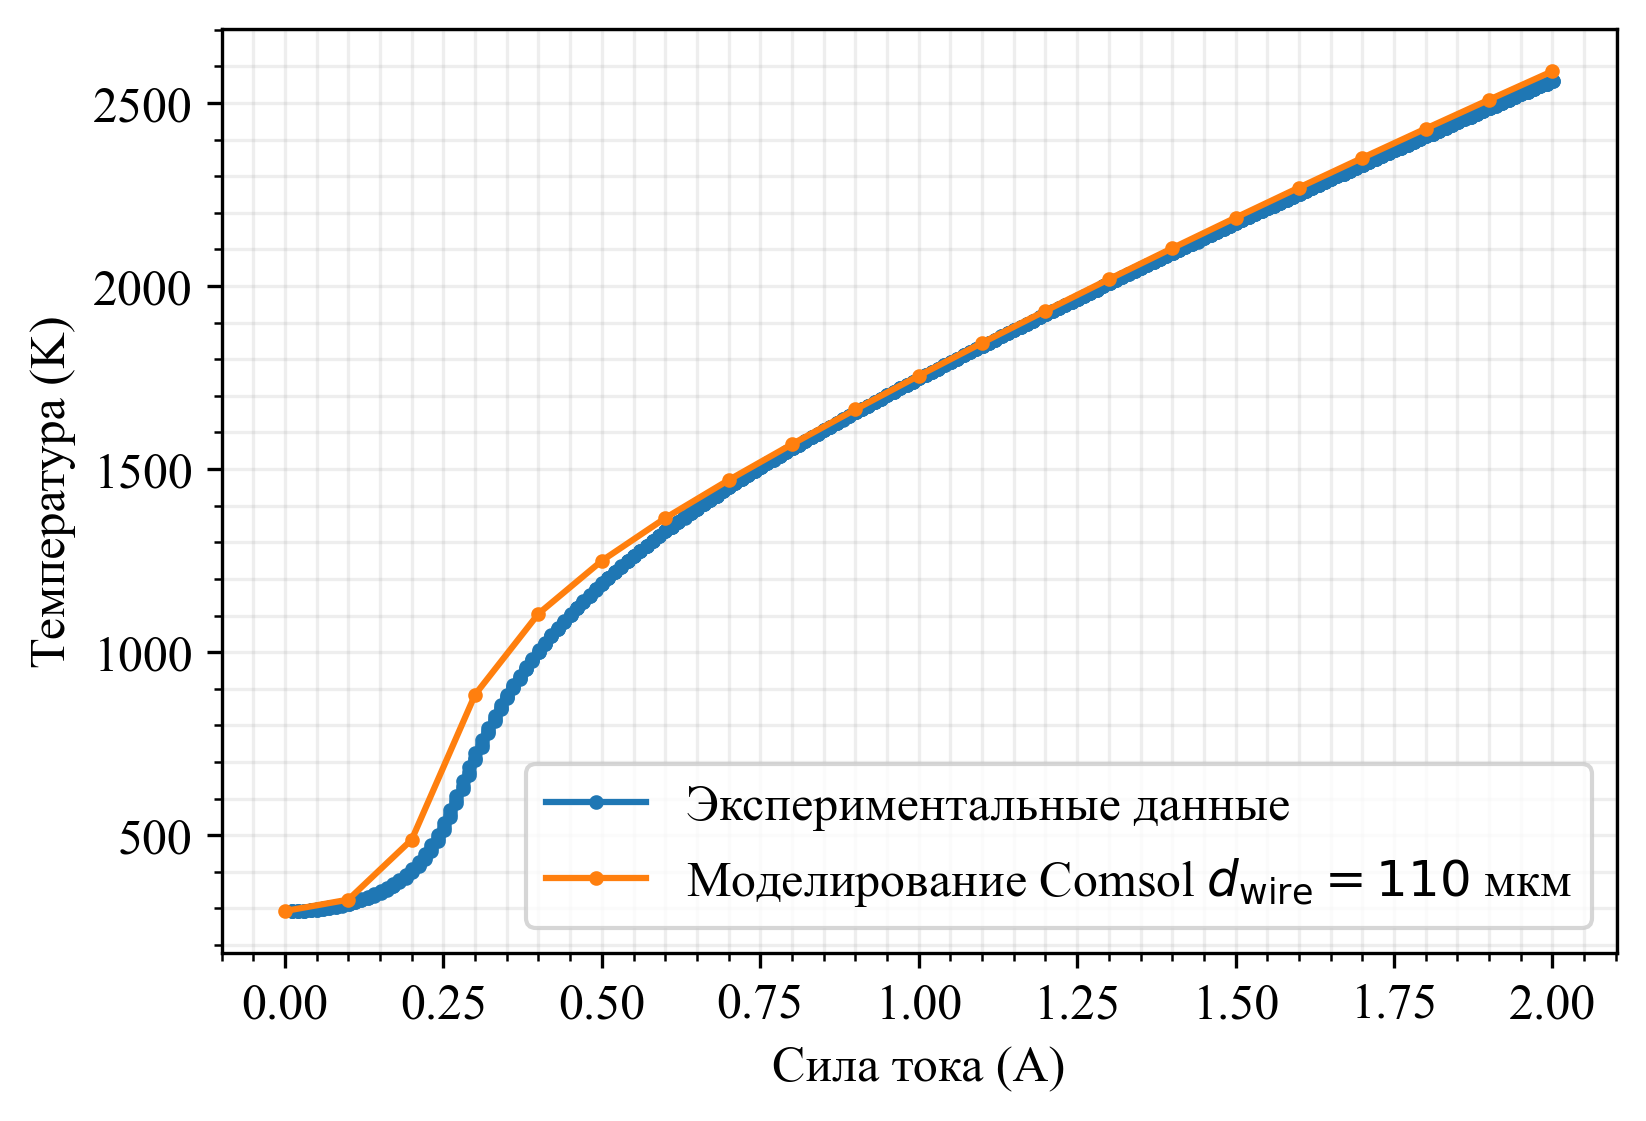

In [47]:

plot({
    'Экспериментальные данные': all_data['1_down.csv'],
    r'Моделирование Comsol $d_\text{wire} = 110$ мкм': {
        'I': Values(label='Сила тока (A)', values=COOMSOL_data[0]),
        'T': Values(label='Температура (K)', values=COOMSOL_data[1])
    }
}, 'I', 'T', fmt='-o')

In [48]:
COOMSOL_data = np.loadtxt('COMSOL_55um_T_on_I.csv', delimiter=',').T


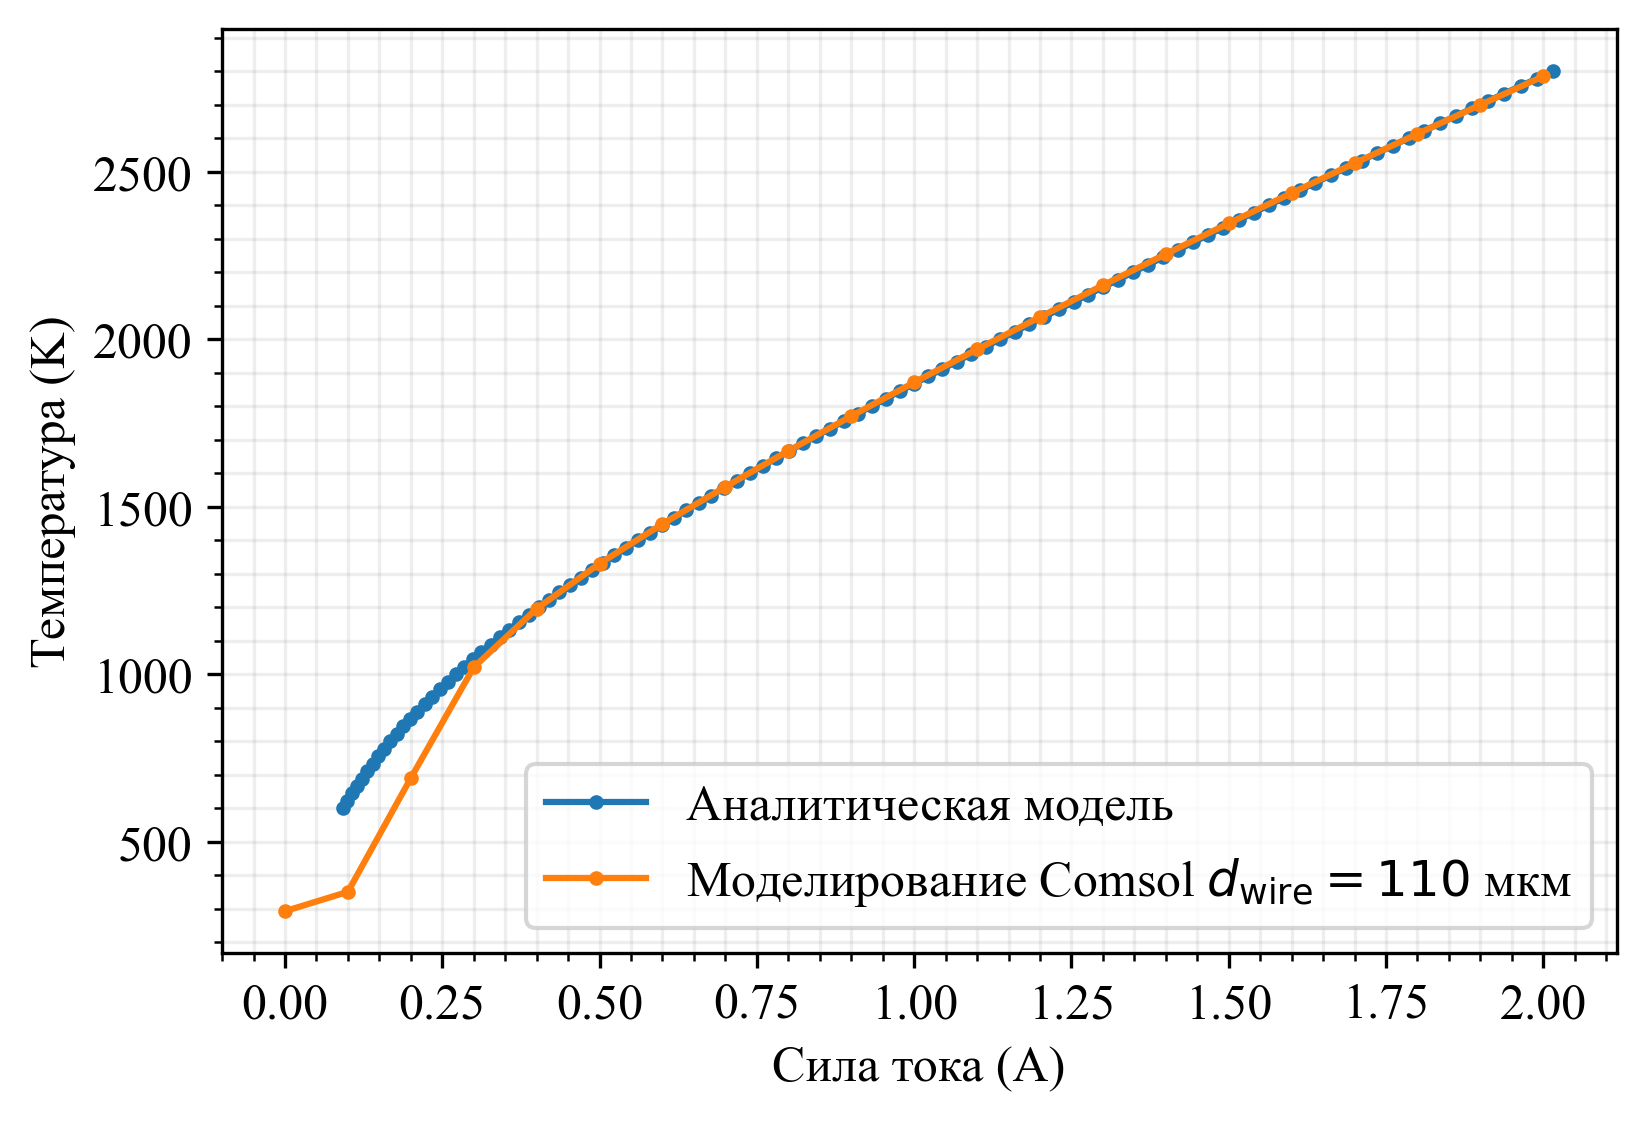

In [49]:
d = 110e-6
sigma = 5.67e-8
rho = lambda T: 5.507e-8 * (T/300)**1.227
epsilon = lambda T: 0.00493+1.01943e-4*T-1.87293e-7*T**2+3.23365e-10*T**3-1.89526e-13*T**4+4.70104e-17*T**5-4.27244e-21*T**6
T_0 = 293.15

I_theory = lambda T: np.pi * (d ** (3/2)) / 2 * np.sqrt(epsilon(T) * sigma * (T**4 - T_0**4) / rho(T))
T_values = np.linspace(600, 2800, 100)
I_values = I_theory(T_values)

idx = COOMSOL_data[0] > .5

plot({
    r'Аналитическая модель': {
        'I': Values(label='Сила тока (A)', values=I_values),
        'T': Values(label='Температура (K)', values=T_values)
    },
    # r'Аналитическая модель': {
    #     'I': Values(label='Сила тока (A)', values=COOMSOL_data[0][idx]+.02),
    #     'T': Values(label='Температура (K)', values=COOMSOL_data[1][idx]*1.03)
    # },
    r'Моделирование Comsol $d_\text{wire} = 110$ мкм': {
        'I': Values(label='Сила тока (A)', values=COOMSOL_data[0]),
        'T': Values(label='Температура (K)', values=COOMSOL_data[1])
    }
}, 'I', 'T', fmt='-o')

In [21]:
[I_values, T_values]

[array([0.09060347, 0.09666367, 0.10294904, 0.10946752, 0.11622654,
        0.12323304, 0.1304936 , 0.13801445, 0.14580152, 0.1538605 ,
        0.16219688, 0.17081596, 0.17972288, 0.18892269, 0.19842036,
        0.2082208 , 0.21832889, 0.22874954, 0.23948768, 0.25054834,
        0.26193662, 0.27365776, 0.28571716, 0.29812043, 0.31087339,
        0.3239821 , 0.33745293, 0.35129256, 0.36550801, 0.38010669,
        0.39509641, 0.41048541, 0.42628244, 0.44249671, 0.45913799,
        0.47621659, 0.49374341, 0.51172999, 0.53018849, 0.54913175,
        0.5685733 , 0.58852739, 0.60900902, 0.63003395, 0.65161873,
        0.67378069, 0.69653802, 0.71990971, 0.74391561, 0.76857646,
        0.79391383, 0.81995021, 0.84670894, 0.87421429, 0.9024914 ,
        0.93156631, 0.96146597, 0.99221822, 1.02385177, 1.05639622,
        1.08988206, 1.12434063, 1.15980411, 1.19630555, 1.2338788 ,
        1.27255853, 1.31238022, 1.35338011, 1.3955952 , 1.43906325,
        1.48382273, 1.52991281, 1.57737335, 1.62

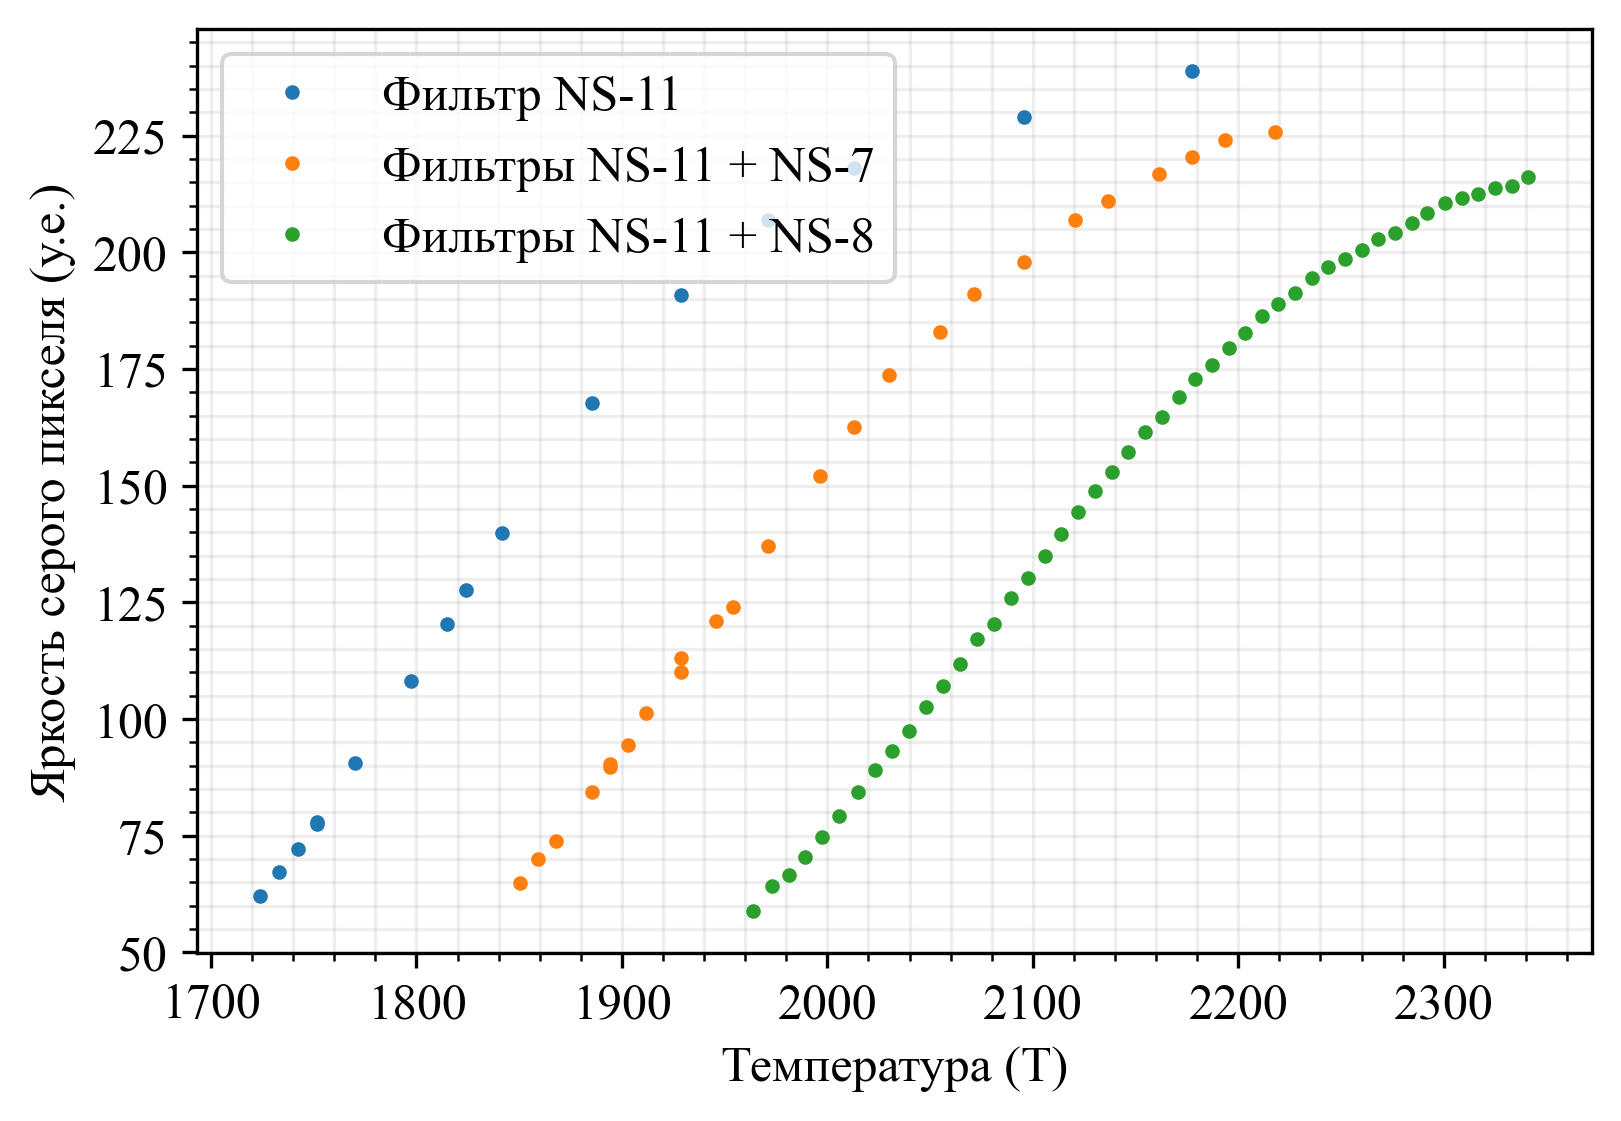

In [22]:
T = lambda I: 108.0958765*I*I*I-511.9765339*I*I+1617.95649045*I+537.60415503
current = np.array([1.241, 1.252, 1.262, 1.271, 1.281, 1.291, 1.302, 1.312, 1.322,
       1.332, 1.342, 1.352, 1.362, 1.372, 1.382, 1.392, 1.402, 1.412,
       1.422, 1.432, 1.442, 1.452, 1.462, 1.472, 1.482, 1.492, 1.502,
       1.512, 1.522, 1.532, 1.542, 1.552, 1.562, 1.572, 1.582, 1.592,
       1.602, 1.612, 1.622, 1.632, 1.641, 1.652, 1.662, 1.672, 1.682,
       1.692, 1.702])

mean = np.array([ 58.81292517,  64.23129252,  66.58163265,  70.40929705,
        74.71655329,  79.29024943,  84.38208617,  89.0430839 ,
        93.08843537,  97.47959184, 102.51020408, 107.15419501,
       111.71088435, 117.03436426, 120.40816327, 125.93424036,
       130.30612245, 135.01683502, 139.69047619, 144.34135166,
       148.86961451, 152.93197279, 157.24603175, 161.51814059,
       164.75056689, 168.88095238, 172.7845805 , 175.87514318,
       179.395189  , 182.6930126 , 186.23922902, 188.99319728,
       191.28798186, 194.53174603, 196.84077892, 198.48412698,
       200.46938776, 202.73129252, 204.08390023, 206.20389462,
       208.47845805, 210.46371882, 211.66893424, 212.5303551 ,
       213.73195876, 214.14739229, 216.20975057])

dataBoth = {"Фильтры NS-11 + NS-8": {
    "T": Values(label="Температура (T)", values=T(current)),
    "I": Values(label="Яркость серого пикселя (у.е.)", values=mean)
}}

from io import StringIO
data = np.loadtxt(StringIO("""1.1 139.8
1.2 190.9
1.3 218.0
1.5 238.8
1.15 167.6
1.05 108.2
1 77.4
0.97 62
0.98 67.1
0.99 72.2
1 78.0
1.02 90.6
1.07 120.4
1.08 127.6
1.25 207
1.4 229
"""), delimiter=' ', dtype=np.float64)
data = data.T

dataNS11 = {"Фильтр NS-11": {
    "T": Values(label="Temperature (T)", values=T(data[0])),
    "I": Values(label="Bightness (a.u.)", values=data[1])
}}

data = np.loadtxt(StringIO("""1.23 124
1.35 183
1.40 198
1.43 207
1.45 211
1.37 191
1.28 152
1.25 137
1.20 110
1.20 113
1.16 90.3
1.17 94.5
1.18 101.3
1.15 84.4
1.13 73.9
1.11 64.9
1.12 69.9
1.16 89.8
1.22 121
1.3 162.5
1.48 216.7
1.5 220.5
1.52 224
1.55 225.7
1.32 173.8
"""), delimiter=' ', dtype=np.float64)
data = data.T

dataNS11NS7 = {"Фильтры NS-11 + NS-7": {
    "T": Values(label="Температура (T)", values=T(data[0])),
    "I": Values(label="Яркость пикселя (a.u.)", values=data[1])
}}

data = {**dataNS11, **dataNS11NS7, **dataBoth}
plot(data, "T", "I", fmt='o')